In [80]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import folium
import numpy as np
from utils import *
%matplotlib inline

In [88]:
def Display_Plot(df:pd.DataFrame, plot_type, axis:pd.DataFrame.axes, title, color):
    if plot_type == "bar":
        # axis.bar(x= df["Year"], height = df["Total Reviews"], color=color, width=2)
        axis.bar(x= df["Year"], height = df["Total Reviews"], color=color)
        for index, col in enumerate(df["Total Reviews"]):
            txt_len = len(str(col))
            axis.annotate(str(col), xy=(index,col), xytext=(-txt_len,txt_len*1.2), textcoords='offset points', rotation=-45)
    elif plot_type == "pie":
        axis.pie(x = df["Total Reviews"], labels = df["Year"], color = color)
    else:
        axis.plot(df["Year"], df["Total Reviews"])
    axis.set_title(title[::-1])
    axis.set_ymargin(0.15)
    axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
    

C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\2302187205.py:11: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"data/{cat}.csv")
C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\1066901308.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\1066901308.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\1066901308.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\1066901308.py:14: UserWarning: FixedFormatter should only be used together with FixedLocat

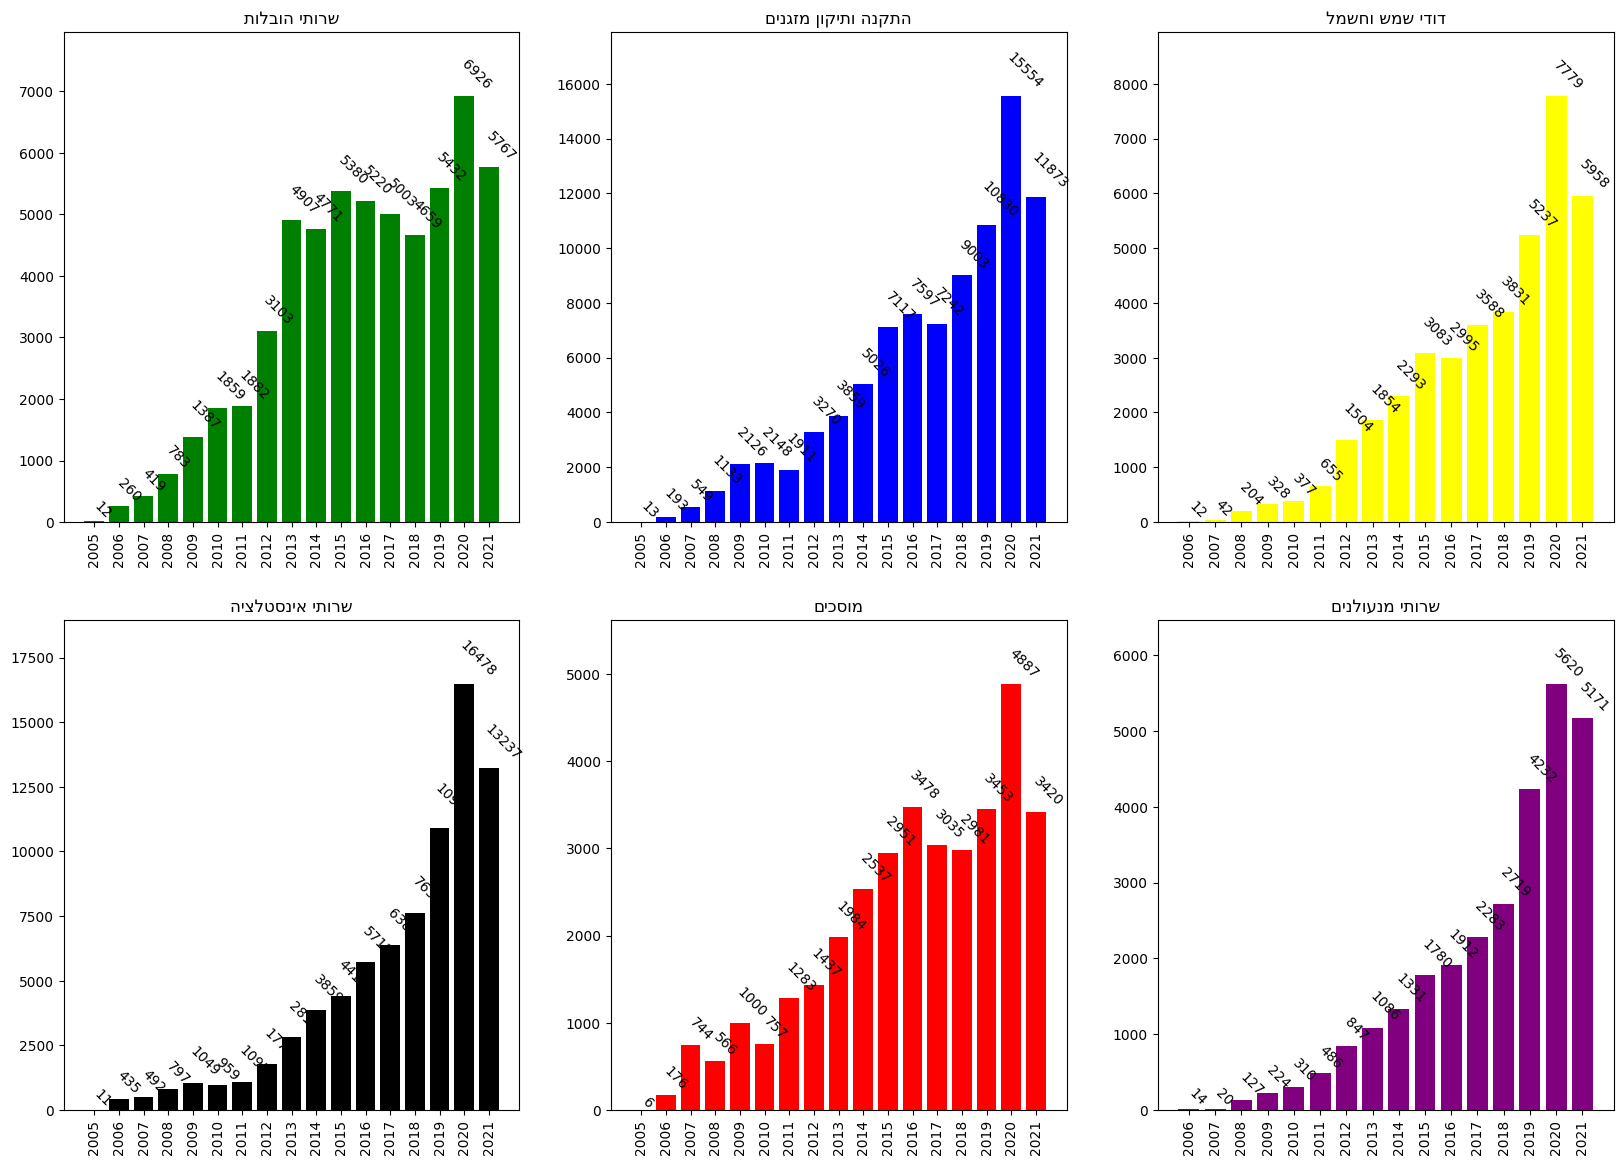

In [89]:
fig, axes = plt.subplots(2,3, figsize=(20,14))
colors = [
    ['green', 'blue','yellow'],
    ['black', 'red', 'purple']
]
# plt.xticks(rotation=90)
categories_csv = Get_All_CSV_Names()
row = 0
index = 0
for cat in categories_csv:
    df = pd.read_csv(f"data/{cat}.csv")
    
    df_dict = pd.DataFrame.from_dict(df["Year"].value_counts().to_dict(), orient="index", columns=["Total Reviews"])
    df_dict.reset_index(inplace=True)
    df_dict.rename(columns={'index':'Year'}, inplace = True)
    df_dict.sort_values(by="Year", inplace=True)
    df_dict['Year'] = df_dict["Year"].astype(str)
    Display_Plot(df_dict, "bar", axes[row, index], cat, colors[row][index])
    
    if index == 2:
        row = 1
        index = 0
    else:
        index+=1
    
    Save_CSV(f"/ML/summery_{cat}.csv", df_dict)

In [81]:
def Display_Graph_Seaborn(df:pd.DataFrame, x_axis, y_axis, hue_title, plot_type, axis:pd.DataFrame.axes, main_title, hue_order):
    if plot_type == 'line':
        sns.lineplot(ax=axis, x=x_axis, y=y_axis, hue=hue_title, hue_order=hue_order, data=df)
        axis.set_title(main_title)
        axis.tick_params(labelrotation=90)

C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\2336148825.py:12: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"data/{csv}.csv")


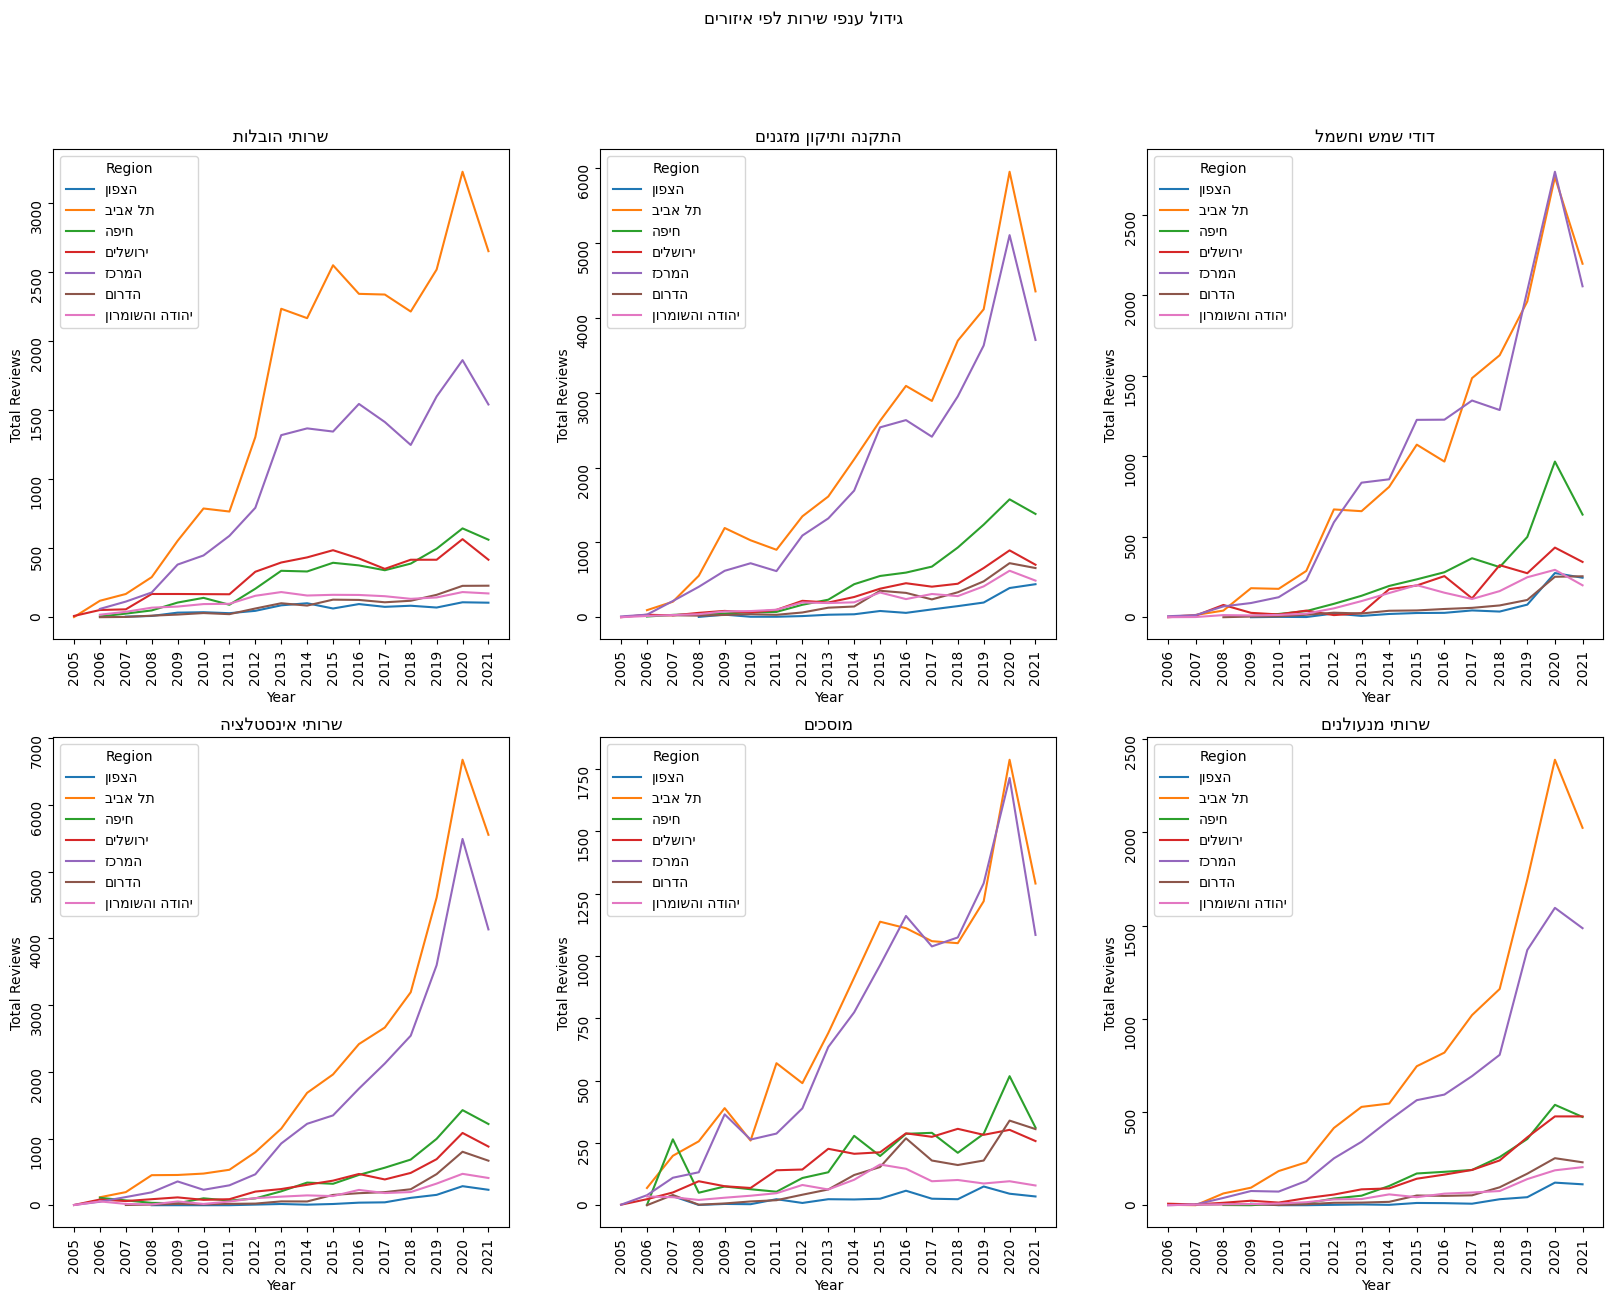

In [82]:
filenames = Get_All_CSV_Names()

fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('גידול ענפי שירות לפי איזורים'[::-1])

regions = ['ןופצה', 'ביבא לת', 'הפיח', 'םילשורי', 'זכרמה', 'םורדה', 'ןורמושהו הדוהי']

row = 0
index = 0

for csv in filenames:
    df = pd.read_csv(f"data/{csv}.csv")
    df.drop(df[df.Region == 'חסוי'].index, inplace=True)
    
    df["Year"] = df["Year"].astype(str)
    df["Region"] = df["Region"].apply(lambda x: x[::-1])
    
    grouped = df.groupby([df['Year'], 'Region'])

    reviews_per_year_and_region = grouped['Region'].count().reset_index(name='Total Reviews')
    
    Display_Graph_Seaborn(reviews_per_year_and_region, "Year", "Total Reviews", "Region", 'line', axes[row,index], csv[::-1], regions)

    if index == 2:
        row = 1
        index = 0
    else:
        index+=1




In [ ]:
# Create a Map that takes array of [locations, total_reviews] as an input, gets the Geo-Location of each location (using OpenStreeMap API) and Pin-Points the Top-5 Locations with the most reviews

# import requests

# map = folium.Map(location=[31.786060, 35.200779], zoom_start=7)

# df = pd.read_csv("data\\reviews.csv")

# df['Location'] = df['Location'].astype(str)
# df['Location'] = df['Location'][~df['Location'].str.contains(r'\d')]
# places = df['Location'].value_counts().to_dict()

# places_dict = []
# for location, total_reviews in places.items():
#     places_dict.append({'name': location, 'total_reviews': total_reviews})

# places_dict= sorted(places_dict, key=lambda x: x['total_reviews'], reverse=True)

# for place in places_dict[:5]:
#     popup = folium.Popup(f'<center><font size="2"><b>{place["name"]}</b></font><br><u>ביקורות</u>: {place["total_reviews"]}', max_width=300)

#     url = f'https://nominatim.openstreetmap.org/search?q={place["name"]}+Israel&format=json'
#     response = requests.get(url).json()
#     if response:
#         lat = response[0]['lat']
#         lon = response[0]['lon']

#     folium.Marker(location=[lat, lon], popup=popup).add_to(map)

# map

In [12]:
# Checking Population of each Town in Israel (after getting the Geo-Location of them)
# df_towns = pd.read_csv("data\\israel_towns.csv")

# map = folium.Map(location=[31.786060, 35.200779], zoom_start=7)

# for index, row in df_towns.iterrows():
#     if( pd.notnull(row['Geo_lat']) & pd.notnull(row['Geo_lon']) ):
#         popup = folium.Popup(f'<center><font size="2"><b>{row["Name"]}</b></font><br><u>תושבים:</u>: {row["Population"]}', max_width=300)

#         folium.Marker(location=[row["Geo_lat"], row["Geo_lon"]], popup=popup).add_to(map)

# map

In [10]:
# Create a dataframe with city names and their corresponding values
# data = {'city': ['ירושלים', 'Tel Aviv', 'Haifa', 'Petah Tikva', 'Ashdod'],
#         'value': [100, 75, 50, 25, 0]}
# df = pd.DataFrame(data)
 
# # Create a map object
# m = folium.Map(location=[31.0461, 34.8516], zoom_start=8)
 
# # Use the geo.json file to create the choropleth map
# folium.Choropleth(
#     geo_data='data/map/israel-geojson.json',
#     data=df,
#     columns=['city', 'value'],
#     key_on='feature.properties.HEB_NAME',
#     fill_color='YlGn',
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name='Value'
# ).add_to(m)
 
# # Add a layer control to toggle the choropleth layer on/off
# folium.LayerControl().add_to(m)
 
# Display the map
# m